In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import regularizers


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [33]:
train_dir = "/Users/harry.lopez/Documents/Dataset/archive/Train"
test_dir = "/Users/harry.lopez/Documents/Dataset/archive/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 46      #Was 46
EPOCHS = 5
LR =  0.00003
NUM_CLASSES = 14
IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69
INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [13]:
crime_types=os.listdir(train_dir)
crime_types.remove('.DS_Store')
print(crime_types)
n=len(crime_types)
print("Number of crime categories : ",n)

['RoadAccidents', 'Arson', 'Shoplifting', 'Stealing', 'Burglary', 'NormalVideos', 'Fighting', 'Vandalism', 'Explosion', 'Arrest', 'Abuse', 'Robbery', 'Assault', 'Shooting']
Number of crime categories :  14


In [14]:
crimes={}
train=test=0
for clss in crime_types:
    if clss != ".DS_Store":
        num=len(os.listdir(os.path.join(train_dir,clss)))
        train+=num
        test+=len(os.listdir(os.path.join(test_dir,clss)))

        crimes[clss]=num

In [15]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(
                                   #horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split=0.2, # set validation split, Added
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [16]:
train_set= image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set= image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set= image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


2023-01-26 11:08:40.109533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [17]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [24]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation="relu", 
                    kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.3))
    
    model.add(Dense(1024, activation="relu"))
    
    model.add(Dense(2048, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(n,activation="softmax",name="classification"))
    
    model.summary()
    
    return model

In [25]:
model=create_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives(), tf.keras.metrics.Accuracy()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [34]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

Epoch 1/5
22024/22024 [==============================] - 8269s 375ms/step - loss: 0.6428 - auc: 0.9980 - true_negatives: 13152706.0000 - true_positives: 984267.0000 - accuracy: 0.2350 - val_loss: 0.5084 - val_auc: 0.9995 - val_true_negatives: 3290548.0000 - val_true_positives: 248042.0000 - val_accuracy: 0.2359
Epoch 2/5
22024/22024 [==============================] - 8307s 377ms/step - loss: 0.5987 - auc: 0.9984 - true_negatives: 13156573.0000 - true_positives: 990657.0000 - accuracy: 0.2669 - val_loss: 0.4767 - val_auc: 0.9994 - val_true_negatives: 3290523.0000 - val_true_positives: 248833.0000 - val_accuracy: 0.3096
Epoch 3/5
22024/22024 [==============================] - 8440s 383ms/step - loss: 0.6056 - auc: 0.9986 - true_negatives: 13158396.0000 - true_positives: 993821.0000 - accuracy: 0.4052 - val_loss: 0.8872 - val_auc: 0.9995 - val_true_negatives: 3290653.0000 - val_true_positives: 249344.0000 - val_accuracy: 0.3027
Epoch 4/5
22024/22024 [==============================] - 8464

In [35]:
y_true =  np.array([])
for x, y in test_set:
    y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [36]:
y_pred=model.predict(test_set)

2420/2420 [==============================] - 411s 170ms/step


In [37]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.7633727947405013


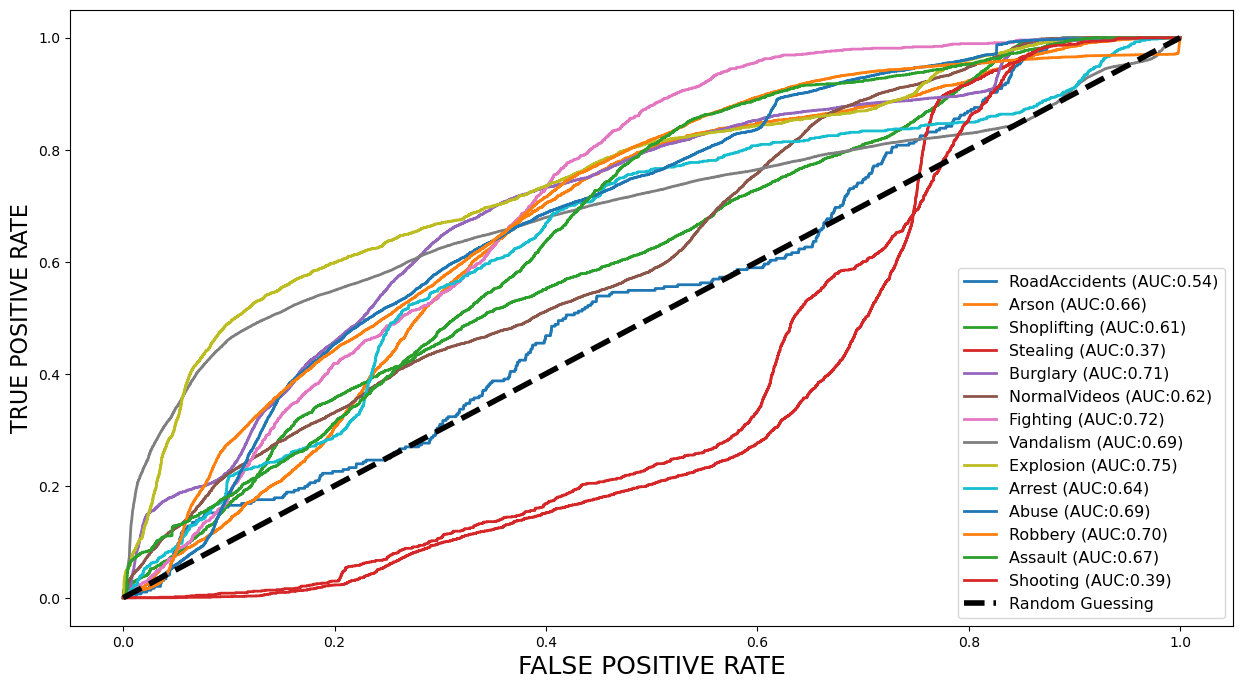

In [38]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score:', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [39]:
model.save('/Users/harry.lopez/Documents/Python/Models/Test3.2.h5')